## Momentum Strategy | Permance Metrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime as dt
import yfinance as yf

np.set_printoptions(precision = 3)
plt.style.use("ggplot")

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["legend.fontsize"] = 14

import warnings
warnings.filterwarnings("ignore")

### Momentum Strategy

[*********************100%%**********************]  1 of 1 completed


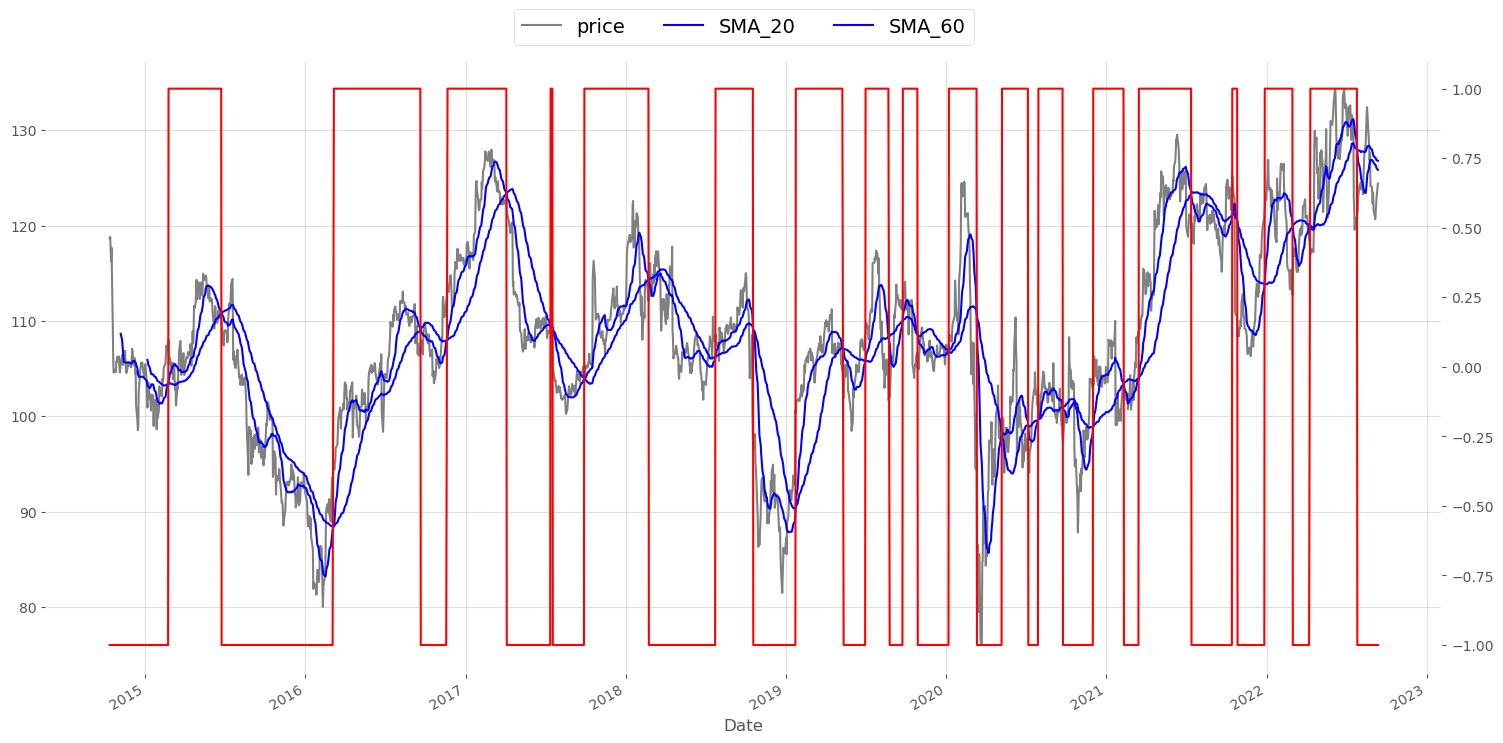

In [2]:
# Momentum Strategy ==> use simple moving average
# set two different moving average -- long SMA and short SMA
# A bullish crossover arises when short SMA turns upward and crosses beyond long SMA ==> buy signal
# A bearish crossover arises when short SMA turns downward and crosses under long SMA ==> sell signal

df = yf.download("IBM",start = dt.datetime(2014,10,13),end = dt.datetime(2022,9,13))[["Adj Close"]]
# create IBM dataframe
IBM = df[["Adj Close"]]
IBM = IBM.rename(columns = {"Adj Close":"price"})

# set moving windows --> 20 and 60 days
# 20 days moving average means that 
IBM["SMA_20"] = IBM["price"].rolling(window = 20).mean()
IBM["SMA_60"] = IBM["price"].rolling(window = 60).mean()

# set positions ==> set buy signal=1 and sell signal=-1
IBM["positions"] = np.where(IBM["SMA_20"] > IBM["SMA_60"],1,-1)

# plot the position and price
IBM[["price","SMA_20","SMA_60","positions"]]\
    .plot(secondary_y = "positions",figsize = (18,9),color = ["grey","blue","blue","red"])\
    .legend(loc = "upper center",ncol = 3,bbox_to_anchor = (0.50,1.10))

<Axes: xlabel='Date'>

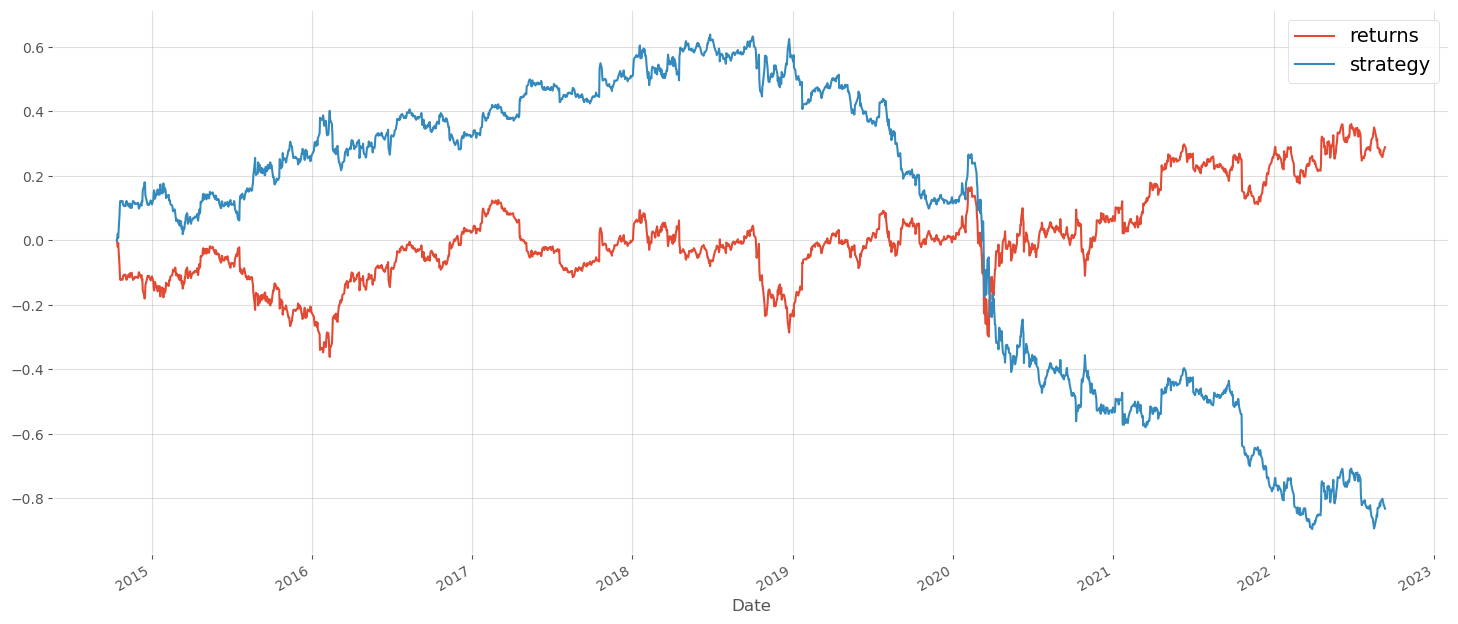

In [3]:
# do backtest to our mean-aversion strategy
# first, calculate returns
IBM["returns"] = IBM["price"].pct_change()

### another way to calculate returns
## IBM["returns"] = IBM["price"].iloc[1:] / IBM["price"].iloc[:-1].values - 1
## IBM["returns"] = IBM["price"] / IBM["price"].shift(1) - 1

# calculate strategy returns --> position must be executed in the next day 
IBM["strategy"] = IBM["positions"].shift(1) * IBM["returns"]

IBM[["returns","strategy"]].dropna().cumsum().plot(figsize = (18,8))

<Axes: xlabel='Date'>

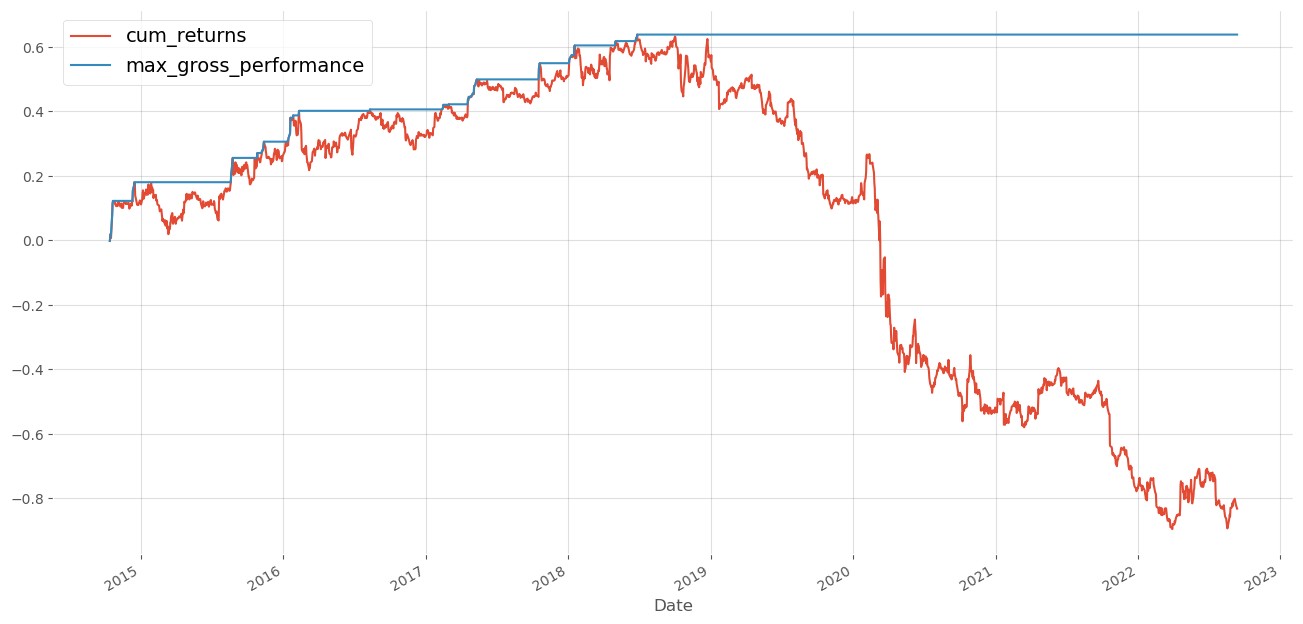

In [4]:
# calculate our cumulative returns based on strategy
IBM["cum_returns"] = IBM["strategy"].cumsum()
# calculate the max gross performance durng the whole period
IBM["max_gross_performance"] = IBM["cum_returns"].cummax()
IBM[["cum_returns","max_gross_performance"]].dropna().plot(figsize = (16,8))

In [6]:
# calculate net drawdown ==> use (cumulative returns minus max gross performance)/max gross performance
drawdown = (IBM["cum_returns"] - IBM["max_gross_performance"]) / IBM["max_gross_performance"]
# get max drawdown
max_drawdown = round(drawdown.min(),4)
# get drawdown period
periods = (drawdown[drawdown == 0].index[1: ] - drawdown[drawdown == 0].index[ :-1]).days
max_drawdown_period = max(periods)

print(f"Max drawdown during this period is {max_drawdown}")
print(f"The logest drawdown period is {max_drawdown_period} days.")

Max drawdown during this period is -2.4026
The logest drawdown period is 248 days.


### Performance Metrics

In [7]:
# Sharpe Ratio
IBM_Sharpe = np.sqrt(253) * (IBM["strategy"].mean()/IBM["strategy"].std())

# Compound Annual Growth Rate (CAGR)
# CAGR = (EndValue / BeginingValue) ** (365 / days) -1
def compound_annual_growth_rate_function(df):
    value = (df["price"][-1] / df["price"][0])
    days = (df.index[-1] - df.index[0]).days
    CAGR = value **(365 / days) - 1
    return CAGR

IBM_CAGR = compound_annual_growth_rate_function(IBM)

# Max drawdown
def drawdown_function(df):
    returns = df["price"].pct_change()
    cumulative_returns = returns.cumsum()
    max_gross_performance = cumulative_returns.cummax()
    drawdown = max_gross_performance - cumulative_returns
    return drawdown

IBM_max_drawdown = drawdown_function(IBM).max()

# Drawdown Duration
def max_drawdown_duration_function(df):
    drawdown_item = pd.DataFrame(drawdown_function(df))
    list_item = drawdown_item[drawdown_item == 0].index[1: ] - drawdown_item[drawdown_item == 0].index[ :-1]
    duration_item_max = list_item.days.max()
    return duration_item_max

IBM_max_drawdown_duration = max_drawdown_duration_function(IBM)

print(f"Sharpe Ratio during this period is {IBM_Sharpe}")
print(f"Compound Annual Growth Rate (CAGR) is {IBM_CAGR}.")

Sharpe Ratio during this period is -0.4279725260714766
Compound Annual Growth Rate (CAGR) is 0.006014508151198861.
